# Regression

## Preparation


In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1500)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import itertools

#plots
#!pip install plotnine
import plotnine
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import bisect
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve 
from plotnine import *
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
"""
Created on Mon Mar 18 18:25:50 2019

Purpose: Analyze input Pandas DataFrame and return stats per column
Details: The function calculates levels for categorical variables and allows to analyze summarized information

To view wide table set following Pandas options:
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',200)
"""
import pandas as pd
def describe_more(df,normalize_ind=False, weight_column=None, skip_columns=[], dropna=False):
    var = [] ; l = [] ; t = []; unq =[]; min_l = []; max_l = [];
    assert isinstance(skip_columns, list), "Argument skip_columns should be list"
    if weight_column is not None:
        if weight_column not in list(df.columns):
            raise AssertionError('weight_column is not a valid column name in the input DataFrame')
      
    for x in df:
        if x in skip_columns:
            pass
        else:
            var.append( x )
            uniq_counts = len(pd.value_counts(df[x],dropna=False))
            uniq_counts = len(pd.value_counts(df[x], dropna=dropna)[pd.value_counts(df[x],dropna=False)>0])
            l.append(uniq_counts)
            t.append( df[ x ].dtypes )
            min_l.append(df[x].apply(str).str.len().min())
            max_l.append(df[x].apply(str).str.len().max())
            if weight_column is not None and x not in skip_columns:
                df2 = df.groupby(x).agg({weight_column: 'sum'}).sort_values(weight_column, ascending=False)
                df2['authtrans_vts_cnt']=((df2[weight_column])/df2[weight_column].sum()).round(2)
                unq.append(df2.head(n=100).to_dict()[weight_column])
            else:
                df_cat_d = df[x].value_counts(normalize=normalize_ind,dropna=False).round(decimals=2)
                df_cat_d = df_cat_d[df_cat_d>0]
                #unq.append(df[x].value_counts().iloc[0:100].to_dict())
                unq.append(df_cat_d.iloc[0:100].to_dict())
            
    levels = pd.DataFrame( { 'A_Variable' : var , 'Levels' : l , 'Datatype' : t ,
                             'Min Length' : min_l,
                             'Max Length': max_l,
                             'Level_Values' : unq} )
    #levels.sort_values( by = 'Levels' , inplace = True )
    return levels

### Load data

In [3]:
#train_df = pd.read_csv('./data/SBA_loans_small.zip')
X_train = pd.read_csv('SBA_loans_train.csv')
X_test  = pd.read_csv('SBA_loans_test.csv')

In [4]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (337186, 20)
Test shape: (112396, 20)


**Review dataset**

In [5]:
X_train.describe()

,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted
count,337186.000000,337186.000000,337186.000000,337186.000000,337140.000000,337186.000000,337186.000000,337186.000000,337186.000000,3.371860e+05,337186.000000,3.371860e+05,3.371860e+05,337186.000000
mean,53839.723945,398565.095974,110.888984,11.310229,1.280204,8.590790,10.977176,2754.662685,0.758050,2.021301e+05,5.643016,1.935411e+05,1.501295e+05,0.175191
std,31173.277974,263305.463724,78.951681,68.753263,0.451661,239.591219,240.184246,12749.672453,0.646786,2.892966e+05,2232.801967,2.847135e+05,2.293072e+05,0.380131
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000e+02,1.000000e+02,0.000000
25%,27604.250000,235210.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.201250e+04,0.000000,3.500000e+04,2.125000e+04,0.000000
50%,55414.000000,445310.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+05,0.000000,9.000000e+04,6.210000e+04,0.000000
75%,83706.000000,561730.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,2.400000e+05,0.000000,2.270000e+05,1.750000e+05,0.000000
max,99999.000000,928120.000000,505.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,1.100000e+07,996262.000000,5.000000e+06,4.869000e+06,1.000000


In [6]:
desc_train = describe_more(X_train)
desc_train

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,City,22070,object,1,30,"{'LOS ANGELES': 4278, 'HOUSTON': 3801, 'NEW YO..."
1,State,52,object,2,3,"{'CA': 49031, 'TX': 26500, 'NY': 21508, 'FL': ..."
2,Zip,26044,int64,1,5,"{90015: 344, 10001: 328, 93401: 308, 33166: 26..."
3,Bank,4834,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 32382, 'WELLS F..."
4,BankState,56,object,2,3,"{'CA': 44497, 'NC': 29717, 'IL': 24674, 'OH': ..."
5,NAICS,1279,int64,1,6,"{0: 75763, 722110: 10456, 722211: 7319, 811111..."
6,Term,372,int64,1,3,"{84: 86087, 60: 33770, 240: 32245, 120: 29056,..."
7,NoEmp,433,int64,1,4,"{1: 57553, 2: 51865, 3: 34228, 4: 27633, 5: 22..."
8,NewExist,4,float64,3,3,"{1.0: 241894, 2.0: 94857, 0.0: 389, nan: 46}"
9,CreateJob,180,int64,1,4,"{0: 236015, 1: 23537, 2: 21779, 3: 10849, 4: 7..."


In [7]:
desc_test = describe_more(X_test)
desc_test

,A_Variable,Levels,Datatype,Min Length,Max Length,Level_Values
0,City,13833,object,1,30,"{'LOS ANGELES': 1473, 'HOUSTON': 1233, 'NEW YO..."
1,State,52,object,2,3,"{'CA': 16311, 'TX': 8802, 'NY': 7259, 'FL': 50..."
2,Zip,18737,int64,1,5,"{90015: 136, 10001: 113, 93401: 97, 59601: 89,..."
3,Bank,3689,object,3,30,"{'BANK OF AMERICA NATL ASSOC': 10781, 'WELLS F..."
4,BankState,53,object,2,3,"{'CA': 14778, 'NC': 9860, 'IL': 8184, 'OH': 72..."
5,NAICS,1225,int64,1,6,"{0: 25411, 722110: 3510, 722211: 2381, 811111:..."
6,Term,349,int64,1,3,"{84: 28712, 60: 11282, 240: 10654, 120: 9750, ..."
7,NoEmp,317,int64,1,4,"{1: 19386, 2: 17413, 3: 11240, 4: 9104, 5: 761..."
8,NewExist,4,float64,3,3,"{1.0: 80457, 2.0: 31773, 0.0: 137, nan: 29}"
9,CreateJob,129,int64,1,4,"{0: 78877, 1: 7848, 2: 7121, 3: 3610, 4: 2599,..."


Explore levels and counts in the `RevLineCr` column. As we can see, some column values needs to be "cleaned"

In [8]:
print(desc_train.iloc[13]["Level_Values"])
print()
print(desc_test.iloc[13]["Level_Values"])

{'N': 157494, '0': 96923, 'Y': 75248, 'T': 5797, nan: 1703, 'R': 7, '1': 6, '`': 2, '2': 1, ',': 1, '7': 1, 'A': 1, '-': 1, 'Q': 1}

{'N': 52800, '0': 32050, 'Y': 25044, 'T': 1906, nan: 587, '1': 4, '`': 3, '3': 1, 'R': 1}


In [9]:
desc_train.iloc[8]["Level_Values"]

{1.0: 241894, 2.0: 94857, 0.0: 389, nan: 46}

In [10]:
print(desc_train.iloc[14]["Level_Values"])
print()
print(desc_test.iloc[14]["Level_Values"])

{'N': 293633, 'Y': 41283, nan: 988, '0': 581, 'C': 284, 'S': 208, 'A': 181, 'R': 28}

{'N': 97799, 'Y': 13888, nan: 302, '0': 169, 'C': 100, 'A': 72, 'S': 59, 'R': 7}


# Question 1 - point

Replace missing values for all columns for both X_train and X_test.
Replace Na's with zero for numerical variables and with "Missing" for categorical

In [11]:
print(X_train.isna().sum())
print()
print(X_test.isna().sum())

City                    9
State                   6
Zip                     0
Bank                  599
BankState             603
NAICS                   0
Term                    0
NoEmp                   0
NewExist               46
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            1703
LowDoc                988
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
Defaulted               0
dtype: int64

City                   4
State                  2
Zip                    0
Bank                 207
BankState            208
NAICS                  0
Term                   0
NoEmp                  0
NewExist              29
CreateJob              0
RetainedJob            0
FranchiseCode          0
UrbanRural             0
RevLineCr            587
LowDoc               302
DisbursementGross      0
BalanceGross           0
GrAppv                 0
SBA_Appv        

#### Cleaning Datasets. RevLineCr and LowDoc both had unusual characters that didn't coincide with the dataset.
#### Then we replace odd values and those for the floats. 
#### Integer columns were also missing data but they were already 0's. 

In [12]:
# Fill X_train
X_train['RevLineCr']= X_train['RevLineCr'].replace(['T','0','nan','R','1','2','7','A','Q'],'Missing')
X_train['LowDoc']= X_train['LowDoc'].replace(['0','C','nan','S','A','R'],'Missing')
X_train = X_train.apply(pd.Series.replace, to_replace=['','()','(',')','-','_',',',';','`','nan'], value="Missing")
##Fill X_test
X_test['RevLineCr']= X_test['RevLineCr'].replace(['T','0','nan','1','3','R'],'Missing')
X_test['LowDoc']= X_test['LowDoc'].replace(['0','C','nan','S','A','R'],'Missing')
X_test = X_test.apply(pd.Series.replace, to_replace=['','()','(',')','-','_',',',';','`','nan'], value="Missing")

In [13]:

X_train['City'] = X_train['City'].fillna('Missing')
X_train['State'] = X_train['State'].fillna('Missing')
X_train['Bank'] = X_train['Bank'].fillna('Missing')
X_train['BankState'] = X_train['BankState'].fillna('Missing')
X_train['RevLineCr'] = X_train['RevLineCr'].fillna('Missing')
X_train['LowDoc'] = X_train['LowDoc'].fillna('Missing')
X_train['NewExist'] = X_train['NewExist'].fillna(float(0.0))

#float
# NewExist
X_test['City'] = X_test['City'].fillna('Missing')
X_test['State'] = X_test['State'].fillna('Missing')
X_test['Bank'] = X_test['Bank'].fillna('Missing')
X_test['BankState'] = X_test['BankState'].fillna('Missing')
X_test['RevLineCr'] = X_test['RevLineCr'].fillna('Missing')
X_test['LowDoc'] = X_test['LowDoc'].fillna('Missing')
X_test['NewExist'] = X_test['NewExist'].fillna(float(0.0))

print(X_train.isna().sum()), print(), print(X_test.isna().sum())

City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
Defaulted            0
dtype: int64

City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
Defaulted            0
dtype: int64


(None, None, None)

#### Here we can see that the datasets have been cleaned. 

In [14]:
desc_train = describe_more(X_train)
desc_test = describe_more(X_test)
print(desc_train.iloc[13]["Level_Values"])
print()
print(desc_test.iloc[13]["Level_Values"])

print(desc_train.iloc[14]["Level_Values"])
print()
print(desc_test.iloc[14]["Level_Values"])

{'N': 157494, 'Missing': 104444, 'Y': 75248}

{'N': 52800, 'Missing': 34552, 'Y': 25044}
{'N': 293633, 'Y': 41283, 'Missing': 2270}

{'N': 97799, 'Y': 13888, 'Missing': 709}


## Question 2 - 1 point

For the categorical variables listed below:  
- Use LabelEncoder to encode if number of levels is more than or equal to 20
- Use one-hot-encoding to encode if number of levels is less than 20. You can use Pandas or `sklearn` approach
- Take following steps with label/one-hot encoders:
    - Define encoder
    - Fit one-hot-encoder on training data only
    - Fit Label encoder on combination of train/test data or modify logic of Label encoder to handle unseen valid values
    - Transform Train/test datasets separately
- Give new columns names "Original-name"_le (for Label encoder), and "Original-name"_valid_value for one-hot-encoder

In [15]:
len_data = len(X_train)
for col in X_train.drop(columns=['Defaulted']).columns:
  if X_train[col].dtype == 'object':
    print("Train_Column ",col," has ",X_train[col].nunique()," values")
print()
len_data_test = len(X_test)
for col in X_test.drop(columns=['Defaulted']).columns:
  if X_test[col].dtype == 'object':
    print("Test_Column ",col," has ",X_test[col].nunique()," values")

Train_Column  City  has  22069  values
Train_Column  State  has  52  values
Train_Column  Bank  has  4834  values
Train_Column  BankState  has  56  values
Train_Column  RevLineCr  has  3  values
Train_Column  LowDoc  has  3  values

Test_Column  City  has  13832  values
Test_Column  State  has  52  values
Test_Column  Bank  has  3689  values
Test_Column  BankState  has  53  values
Test_Column  RevLineCr  has  3  values
Test_Column  LowDoc  has  3  values


#### Must label encode: 'City', ' State', ' Bank', 'BankState'
#### Must One Hot Encode: 'RevLineCr' and 'LowDoc'

In [16]:
enc2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc3 = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc2.fit(X_train[["RevLineCr"]])
result2 = enc2.transform(X_train[["RevLineCr"]])
ohe_columns2 = ["RevLineCr"+"_"+str(x) for x in enc2.categories_[0]]
result_df2 = pd.DataFrame(result2, columns=ohe_columns2)
X_train = pd.concat([X_train, result_df2], axis=1)
result2 = enc2.transform(X_test[["RevLineCr"]])
ohe_columns2 = ["RevLineCr"+"_"+str(x) for x in enc2.categories_[0]]
result_df2 = pd.DataFrame(result2, columns=ohe_columns2)
X_test = pd.concat([X_test, result_df2], axis=1)

enc3.fit(X_train[["LowDoc"]])
result3 = enc3.transform(X_train[["LowDoc"]])
ohe_columns3 = ["LowDoc"+"_"+str(x) for x in enc3.categories_[0]]
result_df3 = pd.DataFrame(result3, columns=ohe_columns3)
X_train = pd.concat([X_train, result_df3], axis=1)
result3 = enc3.transform(X_test[["LowDoc"]])
ohe_columns3 = ["LowDoc"+"_"+str(x) for x in enc3.categories_[0]]
result_df3 = pd.DataFrame(result3, columns=ohe_columns3)
X_test = pd.concat([X_test, result_df3], axis=1)

In [17]:
## Drop the original columns that we just encoded
X_train.drop(['RevLineCr'], axis = 1, inplace = True)
X_train.drop(['LowDoc'], axis = 1, inplace = True)

X_test.drop(['RevLineCr'], axis = 1, inplace = True)
X_test.drop(['LowDoc'], axis = 1, inplace = True)

#### Now we will label encode 'City', ' State', ' Bank', and 'BankState'.

In [18]:
train_test = pd.concat([X_test.assign(ind="test"), X_train.assign(ind="train")])
le = LabelEncoder()
le2= LabelEncoder()
le3= LabelEncoder()
le4 = LabelEncoder()

train_test['City'] = le.fit_transform(train_test['City'])
train_test['State'] = le2.fit_transform(train_test['State'])
train_test['Bank'] = le3.fit_transform(train_test['Bank'])
train_test['BankState'] = le4.fit_transform(train_test['BankState'])

X_test, X_train = train_test[train_test["ind"].eq("test")], train_test[train_test["ind"].eq("train")]
X_train.drop('ind', axis=1, inplace=True)
X_test.drop('ind', axis =1, inplace=True)

In [19]:
## Now that they are encoded I labeled them with _le to know the method in which they are encoded as I move forward.
X_train.columns= X_train.columns.map(lambda x : x+'_le' if x =='City' or x=='State' or x=='Bank'or x =='BankState' else x)
X_test.columns= X_test.columns.map(lambda x : x+'_le' if x =='City' or x=='State' or x=='Bank'or x =='BankState' else x)

n = 5
first_5  = X_train.iloc[:2 , :n]
print(first_5, '--Verify encoding and name change on label encoded columns for X_train',)
print()
first_5  = X_test.iloc[:2 , :n]
print(first_5,'--Verify encoding and name change on label encoded columns for X_test')

   City_le  State_le    Zip  Bank_le  BankState_le
0    10026         1  35811      803            11
1    19481         3  85254     4997             5 --Verify encoding and name change on label encoded columns for X_train

   City_le  State_le    Zip  Bank_le  BankState_le
0    17998        14  61866      789            16
1     1743        13  83704     4997            45 --Verify encoding and name change on label encoded columns for X_test


In [20]:
X_train

,City_le,State_le,Zip,Bank_le,BankState_le,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted,RevLineCr_Missing,RevLineCr_N,RevLineCr_Y,LowDoc_Missing,LowDoc_N,LowDoc_Y
0,10026,1,35811,803,11,621310,73,1,2.0,2,1,0,1,25000.0,0.0,25000.0,21250.0,1,0.0,1.0,0.0,0.0,1.0,0.0
1,19481,3,85254,4997,5,0,84,3,2.0,0,0,0,0,52000.0,0.0,52000.0,46800.0,1,0.0,1.0,0.0,0.0,1.0,0.0
2,1057,21,4401,381,23,323110,84,9,1.0,0,0,1,1,150000.0,0.0,150000.0,127500.0,0,1.0,0.0,0.0,0.0,0.0,1.0
3,739,3,85323,3292,4,722110,27,20,1.0,0,20,10625,2,186959.0,0.0,100000.0,50000.0,1,0.0,0.0,1.0,0.0,1.0,0.0
4,8868,18,70403,708,20,0,60,1,1.0,0,0,1,1,50000.0,0.0,50000.0,40000.0,0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337181,18363,23,55901,4759,25,722410,240,8,1.0,4,8,1,2,388000.0,0.0,388000.0,388000.0,0,1.0,0.0,0.0,0.0,1.0,0.0
337182,20616,35,10301,407,30,445110,36,4,2.0,0,4,0,1,31500.0,0.0,31500.0,15750.0,0,0.0,0.0,1.0,0.0,1.0,0.0
337183,14448,39,18936,4845,34,311811,120,2,2.0,15,0,25650,1,720000.0,0.0,720000.0,540000.0,0,0.0,1.0,0.0,0.0,1.0,0.0
337184,9093,13,83835,3267,15,441229,84,2,1.0,1,1,1,1,210282.0,0.0,110000.0,55000.0,0,0.0,0.0,1.0,0.0,1.0,0.0


## Question 3 - 1 point

Use MinMax scaler to scale numerical variables. Be careful not to scale new columns you have created as part of categorical features encoding. 
Add new columns containing scaled values as "Original_name"_sc

In [21]:
len_data = len(X_train)
for col in X_train.drop(columns=['Defaulted']).columns:
  if  X_train[col].dtype == 'int64' or X_train[col].dtype == 'float':
    print("Train_Column ",col," has ",X_train[col].nunique()," values")

Train_Column  Zip  has  26044  values
Train_Column  NAICS  has  1279  values
Train_Column  Term  has  372  values
Train_Column  NoEmp  has  433  values
Train_Column  NewExist  has  3  values
Train_Column  CreateJob  has  180  values
Train_Column  RetainedJob  has  274  values
Train_Column  FranchiseCode  has  1976  values
Train_Column  UrbanRural  has  3  values
Train_Column  DisbursementGross  has  58004  values
Train_Column  BalanceGross  has  5  values
Train_Column  GrAppv  has  12432  values
Train_Column  SBA_Appv  has  21440  values
Train_Column  RevLineCr_Missing  has  2  values
Train_Column  RevLineCr_N  has  2  values
Train_Column  RevLineCr_Y  has  2  values
Train_Column  LowDoc_Missing  has  2  values
Train_Column  LowDoc_N  has  2  values
Train_Column  LowDoc_Y  has  2  values


In [22]:
# Columns to scale, not inculding those encoded
# SBA_Appv, GrAppv, DisbursementGross, are floats
# UrbanRural, FranchiseCode, RetainedJob, CreateJob, NoEmp, Term, NAICS, Zip are integers 

# Zip, NAICS, Term, NoEmp, CreateJob, RetainedJob, FranchiseCode, UrbanRural,/// DisbursementGross,Balance, Gross, SBA_Appv, GrAppv 

In [23]:
scaler_min_max = MinMaxScaler()

X_train[['Zip','NAICS','Term','NewExist','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','DisbursementGross','BalanceGross','SBA_Appv','GrAppv']] = scaler_min_max.fit_transform(X_train[['Zip','NAICS','Term','NewExist','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','DisbursementGross','BalanceGross','SBA_Appv','GrAppv']])

X_test[['Zip','NAICS','Term','NewExist','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','DisbursementGross','BalanceGross','SBA_Appv','GrAppv']] = scaler_min_max.transform(X_test[['Zip','NAICS','Term','NewExist','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','DisbursementGross','BalanceGross','SBA_Appv','GrAppv']])

In [24]:
X_train.columns= X_train.columns.map(lambda x : x+'_sc' if x =='Zip' or x=='NAICS' or x=='Term'or x =='NewExist' or x=='NoEmp' or x=='CreateJob' or x=='RetainedJob' or x=='FranchiseCode' or x=='UrbanRural' or x=='DisbursementGross' or x=='BalanceGross' or x=='SBA_Appv' or x=='GrAppv' else x)
X_test.columns = X_test.columns.map(lambda x : x+'_sc' if x =='Zip' or x=='NAICS' or x=='Term'or x =='NewExist' or x=='NoEmp' or x=='CreateJob' or x=='RetainedJob' or x=='FranchiseCode' or x=='UrbanRural' or x=='DisbursementGross' or x=='BalanceGross' or x=='SBA_Appv' or x=='GrAppv' else x)

In [25]:
X_train

,City_le,State_le,Zip_sc,Bank_le,BankState_le,NAICS_sc,Term_sc,NoEmp_sc,NewExist_sc,CreateJob_sc,RetainedJob_sc,FranchiseCode_sc,UrbanRural_sc,DisbursementGross_sc,BalanceGross_sc,GrAppv_sc,SBA_Appv_sc,Defaulted,RevLineCr_Missing,RevLineCr_N,RevLineCr_Y,LowDoc_Missing,LowDoc_N,LowDoc_Y
0,10026,1,0.358114,803,11,0.669429,0.144554,0.0001,1.0,0.000227,0.000105,0.000000,0.5,0.002273,0.0,0.004960,0.004344,1,0.0,1.0,0.0,0.0,1.0,0.0
1,19481,3,0.852549,4997,5,0.000000,0.166337,0.0003,1.0,0.000000,0.000000,0.000000,0.0,0.004727,0.0,0.010360,0.009591,1,0.0,1.0,0.0,0.0,1.0,0.0
2,1057,21,0.044010,381,23,0.348134,0.166337,0.0009,0.5,0.000000,0.000000,0.000010,0.5,0.013636,0.0,0.029961,0.026166,0,1.0,0.0,0.0,0.0,0.0,1.0
3,739,3,0.853239,3292,4,0.778035,0.053465,0.0020,0.5,0.000000,0.002105,0.106251,1.0,0.016996,0.0,0.019961,0.010249,1,0.0,0.0,1.0,0.0,1.0,0.0
4,8868,18,0.704037,708,20,0.000000,0.118812,0.0001,0.5,0.000000,0.000000,0.000010,0.5,0.004545,0.0,0.009960,0.008195,0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337181,18363,23,0.559016,4759,25,0.778358,0.475248,0.0008,0.5,0.000455,0.000842,0.000010,1.0,0.035273,0.0,0.077563,0.079669,0,1.0,0.0,0.0,0.0,1.0,0.0
337182,20616,35,0.103011,407,30,0.479582,0.071287,0.0004,1.0,0.000000,0.000421,0.000000,0.5,0.002864,0.0,0.006260,0.003214,0,0.0,0.0,1.0,0.0,1.0,0.0
337183,14448,39,0.189362,4845,34,0.335960,0.237624,0.0002,1.0,0.001705,0.000000,0.256503,0.5,0.065455,0.0,0.143966,0.110887,0,0.0,1.0,0.0,0.0,1.0,0.0
337184,9093,13,0.838358,3267,15,0.475401,0.166337,0.0002,0.5,0.000114,0.000105,0.000010,0.5,0.019117,0.0,0.021961,0.011276,0,0.0,0.0,1.0,0.0,1.0,0.0


In [26]:
X_test

,City_le,State_le,Zip_sc,Bank_le,BankState_le,NAICS_sc,Term_sc,NoEmp_sc,NewExist_sc,CreateJob_sc,RetainedJob_sc,FranchiseCode_sc,UrbanRural_sc,DisbursementGross_sc,BalanceGross_sc,GrAppv_sc,SBA_Appv_sc,Defaulted,RevLineCr_Missing,RevLineCr_N,RevLineCr_Y,LowDoc_Missing,LowDoc_N,LowDoc_Y
0,17998,14,0.618666,789,16,0.000000,0.166337,0.0001,1.0,0.000000,0.000000,0.00001,0.0,0.003818,0.0,0.008360,0.006880,0,0.0,1.0,0.0,0.0,0.0,1.0
1,1743,13,0.837048,4997,45,0.000000,0.166337,0.0007,0.5,0.000000,0.000000,0.00001,0.0,0.001364,0.0,0.002960,0.002752,0,0.0,1.0,0.0,0.0,1.0,0.0
2,3043,14,0.601886,4126,16,0.000000,0.475248,0.0019,0.5,0.001705,0.000000,0.00001,0.0,0.045182,0.0,0.099364,0.102056,0,0.0,1.0,0.0,0.0,1.0,0.0
3,20062,31,0.038780,1055,33,0.253857,0.166337,0.0021,0.5,0.000000,0.002211,0.00001,0.5,0.001818,0.0,0.003960,0.002033,0,0.0,0.0,1.0,0.0,1.0,0.0
4,3431,32,0.080021,1055,43,0.583449,0.166337,0.0002,1.0,0.000114,0.000316,0.00001,0.5,0.009091,0.0,0.019961,0.010249,0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112391,9687,50,0.255263,5008,54,0.000000,0.118812,0.0006,0.5,0.000000,0.000000,0.00001,0.0,0.002115,0.0,0.004900,0.004038,0,0.0,1.0,0.0,0.0,0.0,1.0
112392,81,37,0.748207,4937,39,0.778144,0.154455,0.0002,0.5,0.001136,0.000000,0.00001,1.0,0.010909,0.0,0.023961,0.012303,1,1.0,0.0,0.0,0.0,1.0,0.0
112393,11129,4,0.906389,668,5,0.670171,0.154455,0.0001,1.0,0.000000,0.000000,0.00000,0.5,0.001818,0.0,0.003960,0.003471,1,0.0,1.0,0.0,0.0,1.0,0.0
112394,12012,4,0.900219,857,49,0.339624,0.166337,0.0003,0.5,0.000455,0.000316,0.00000,0.5,0.002273,0.0,0.004960,0.002547,0,0.0,1.0,0.0,0.0,1.0,0.0


## Question 4 - 3 points

Train `LogisticRegression` regression on the Train dataset. Score Test dataset. Report performance metrics for for both, Train and Test datasets:
- Accuracy

Identify probability threshold which produces best F1 score. Print following for the found threshold:
- F1 score "weighted" : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
- Confusion matrix

Use `predict_proba` to get probabilities.

In [27]:
X_train_cleaned = X_train.copy()
Y_train = X_train['Defaulted'].copy()
X_train_cleaned.drop(['Defaulted'], axis = 1, inplace = True)

X_test_cleaned = X_test.copy()
Y_test = X_test['Defaulted'].copy()
X_test_cleaned.drop(['Defaulted'], axis = 1, inplace = True)

In [28]:
Y_train.sum()/len(Y_train) ##significantly imbalanced. 

0.17519114079469492

#### The classes are severly imbalanced. I'll try two different methods to generate a score. First will be through penalizing
#### through ridge and lasso. Then I'll try to generate the f1 score with the optimal threshold. 

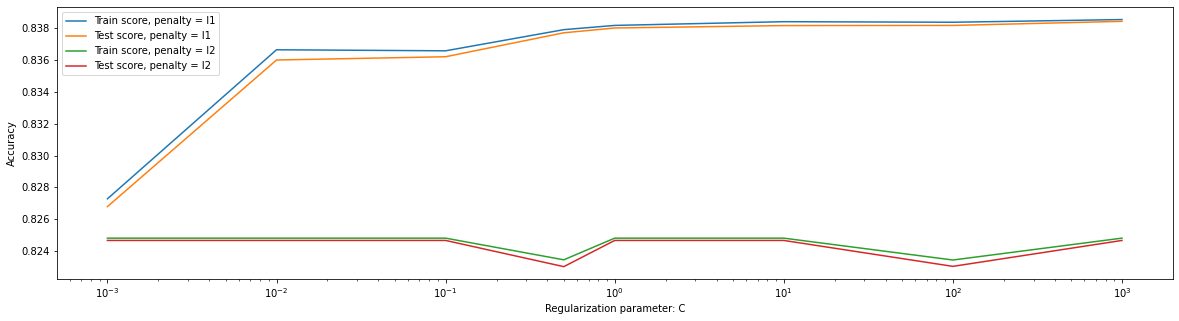

In [29]:
from sklearn.linear_model import LogisticRegression

##Lecture Route
c_range = [0.001, 0.01, 0.1,.5, 1, 10, 100, 1000]
train_score_l1 = []
train_score_l2 = []
test_score_l1 = []
test_score_l2 = []

for c in c_range:
    LogisticRegressionl1 = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', max_iter = 500)
    LogisticRegressionl2 = LogisticRegression(penalty = 'l2', C = c, solver = 'lbfgs', max_iter = 500)
    LogisticRegressionl1.fit(X_train_cleaned, Y_train)
    LogisticRegressionl2.fit(X_train_cleaned, Y_train)
    train_score_l1.append(LogisticRegressionl1.score(X_train_cleaned, Y_train))
    train_score_l2.append(LogisticRegressionl2.score(X_train_cleaned, Y_train))
    test_score_l1.append(LogisticRegressionl1.score(X_test_cleaned, Y_test))
    test_score_l2.append(LogisticRegressionl2.score(X_test_cleaned, Y_test))

    ## Now we plot to see the difference in penalty and which yields a better score. 
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize = (20,5))
plt.plot(c_range, train_score_l1, label = 'Train score, penalty = l1')
plt.plot(c_range, test_score_l1, label = 'Test score, penalty = l1')
plt.plot(c_range, train_score_l2, label = 'Train score, penalty = l2')
plt.plot(c_range, test_score_l2, label = 'Test score, penalty = l2')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel('Accuracy')
plt.xscale('log')

In [30]:
## Train Score was 0.8248088592053051
## Test score was 0.8246645788106338

from sklearn.linear_model import LogisticRegression

LogisticRegression = LogisticRegression(penalty = 'l2', C = .01, solver = 'lbfgs', max_iter = 500)
LogisticRegression.fit(X_train_cleaned, Y_train)

predict_train = LogisticRegression.predict(X_train_cleaned)
print('Predict:',predict_train)

print()
proba_test =LogisticRegression.predict_proba(X_test_cleaned)
print('Predict_proba: With L2 penalty',proba_test)

##Accuracy
y_trained = LogisticRegression.score(X_train_cleaned, Y_train)
y_tested = LogisticRegression.score(X_test_cleaned, Y_test)
print()
print('Train score:',y_trained)
print()
print('Test score:',y_tested)

Predict: [0 0 0 ... 0 0 0]

Predict_proba: With L2 penalty [[0.87945452 0.12054548]
 [0.90337011 0.09662989]
 [0.90380836 0.09619164]
 ...
 [0.83660564 0.16339436]
 [0.83706364 0.16293636]
 [0.91072924 0.08927076]]

Train score: 0.8248088592053051

Test score: 0.8246645788106338


#### Now I will tune for the threshold and the weighted F1score.

In [31]:
y_pred = proba_test[:, 1]


thresholds = np.arange(0.1, 1.0, 0.005)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

##model fitting for the threshold array outlined above
for index, elem in enumerate(thresholds):
    y_pred_prob = (y_pred > elem).astype('int')
    fscore[index] = f1_score(Y_test, y_pred_prob, average='weighted')

Length of sequence: 180


Optimal Threshold: 0.335 with F-Score: 0.757


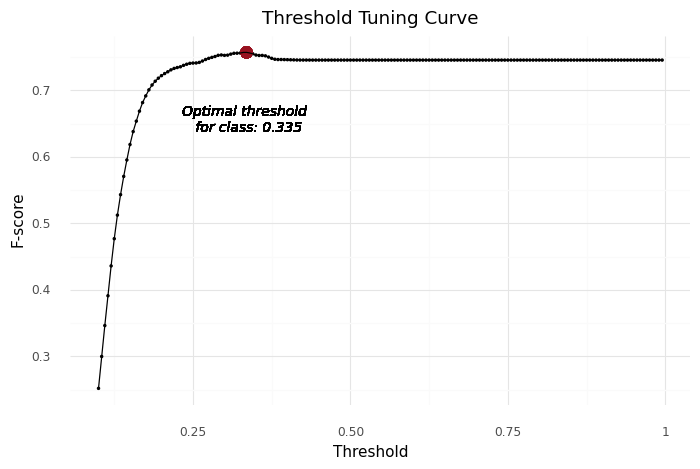

<ggplot: (173081279636)>

In [32]:
##Optimal Threshold: 0.335 with F-Score: 0.757

index = np.argmax(fscore)
optimized_threshold= round(thresholds[index], ndigits = 4)
optimized_fscore = round(fscore[index], ndigits = 4)
print('Optimal Threshold: {} with F-Score: {}'.format(optimized_threshold, optimized_fscore))


tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
tuning.head()
## now we plot the threshold
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = optimized_threshold,
                   y = optimized_fscore),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = optimized_threshold,
                  y = optimized_fscore),
              label = 'Optimal threshold \n for class: {}'.format(optimized_threshold),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

In [33]:
threshold = 0.335

# Creating pred model based on threshold
preds_test = np.where(LogisticRegression.predict_proba(X_test_cleaned)[:,1] > threshold, 1, 0)

preds_train = np.where(LogisticRegression.predict_proba(X_train_cleaned)[:,1] > threshold, 1, 0)

In [34]:
## finally the Fscore with confusion matrices labeled for both train and test

In [35]:
## Weighted F1_score for train is .76 with .81 accuracy at the .335 threshold

print(classification_report(Y_train,preds_train))
print()

labels = np.unique(Y_train)
confusion = metrics.confusion_matrix(Y_train, preds_train, labels = np.unique(Y_train))
print('Confusion matrix for train')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Crosstab for Confusion matrix')
pd.crosstab(Y_train, preds_train, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89    278114
           1       0.31      0.09      0.13     59072

    accuracy                           0.81    337186
   macro avg       0.57      0.52      0.51    337186
weighted avg       0.74      0.81      0.76    337186


Confusion matrix for train
        0      1
0  267084  11030
1   54040   5032

Crosstab for Confusion matrix


Predicted,0,1,All
True,,,
0,267084,11030,278114
1,54040,5032,59072
All,321124,16062,337186


In [36]:
## Weighted F1_score for test is .76 with .8 accuracy at the .335 threshold

print(classification_report(Y_test,preds_test))
print()
labels = np.unique(Y_test)
confusion = metrics.confusion_matrix(Y_test, preds_test, labels = np.unique(Y_test))
print('Confusion matrix for test')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Crosstab for Confusion matrix')
pd.crosstab(Y_test, preds_test, rownames=['True'], colnames=['Predicted'], margins=True)


              precision    recall  f1-score   support

           0       0.83      0.96      0.89     92689
           1       0.30      0.08      0.13     19707

    accuracy                           0.81    112396
   macro avg       0.57      0.52      0.51    112396
weighted avg       0.74      0.81      0.76    112396


Confusion matrix for test
       0     1
0  89050  3639
1  18134  1573

Crosstab for Confusion matrix


Predicted,0,1,All
True,,,
0,89050,3639,92689
1,18134,1573,19707
All,107184,5212,112396


## Question 5 - 5 points

Train SVM (`from sklearn.svm import SVC`) classifier with following hyper-parameters. 
```
for degree in [2,3,4,5,7]:
    svm = SVC(kernel='poly', degree=degree, max_iter=700, verbose=False)
```    

Report:  
- F1 score "weighted" : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
- Confusion matrix

What is the best degree from the weighted F1 stand point? 

In [37]:
X_train_svm = X_train.copy()
Y_train_svm = X_train['Defaulted'].copy()
X_train_svm.drop(['Defaulted'], axis = 1, inplace = True)

X_test_svm= X_test.copy()
Y_test_svm = X_test['Defaulted'].copy()
X_test_svm.drop(['Defaulted'], axis = 1, inplace = True)

## We set the parameters to use for the best estimator. 
svm = SVC(kernel='poly', max_iter=700, verbose=False)
degree = [2,3,4,5,7]
parameters = dict(degree = degree)

##utilize the best estimator to find the best degree
GridSearch = GridSearchCV(svm, parameters)
Fitted_Model = GridSearch.fit(X_train_svm, Y_train_svm)
print(Fitted_Model.best_estimator_.get_params()['degree'])

2


In [38]:
## degree 2 is the best from a weighted f1 score standpoint

#### Now that we know the best degree, we run the model with degree 2 in the parameter and find the weighted f_score

In [39]:
SVM = SVC(kernel='poly', degree=2, max_iter=700, verbose=False)

SVM.fit(X_train_svm,Y_train)
SVM_y_pred = SVM.predict(X_test_svm)

labels = np.unique(Y_test_svm)
confusion = metrics.confusion_matrix(Y_test_svm, SVM_y_pred, labels = np.unique(Y_test))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Classification Report')
print(classification_report(Y_test_svm, SVM_y_pred))

Confusion matrix
       0      1
0  67892  24797
1  15122   4585

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.73      0.77     92689
           1       0.16      0.23      0.19     19707

    accuracy                           0.64    112396
   macro avg       0.49      0.48      0.48    112396
weighted avg       0.70      0.64      0.67    112396



#### I'll also use an alternate method to verify the estimator. I'll now run the models separately for each degree then see if the best is degree 2. 

In [40]:
## create separate Svm for each degree
svm2 = SVC(kernel='poly', degree=2, max_iter=700, verbose=False)
svm3= SVC(kernel='poly', degree=3, max_iter=700, verbose=False)
svm4 = SVC(kernel='poly', degree=4, max_iter=700, verbose=False)
svm5 = SVC(kernel='poly', degree=5, max_iter=700, verbose=False)
svm7 = SVC(kernel='poly', degree=7, max_iter=700, verbose=False)

In [41]:
X_train_svm2 = X_train.copy()
X_train_svm2.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_svm2 = X_train['Defaulted'].copy()
X_test_svm2 = X_test.copy()
X_test_svm2.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_svm2 = X_test['Defaulted'].copy()
svm2.fit(X_train_svm2,Y_train_svm2)
y_pred2 = svm2.predict(X_test_svm2)
print(y_pred2)
print('Degree 2')
labels = np.unique(Y_test_svm2)
confusion = metrics.confusion_matrix(Y_test_svm2,y_pred2, labels = np.unique(Y_test_svm2))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Classification Report')
print(classification_report(Y_test_svm2, y_pred2))

X_train_svm3 = X_train.copy()
X_train_svm3.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_svm3 = X_train['Defaulted'].copy()
X_test_svm3 = X_test.copy()
X_test_svm3.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_svm3 = X_test['Defaulted'].copy()
svm3.fit(X_train_svm3,Y_train_svm3)
y_pred3 = svm3.predict(X_test_svm3)
print(y_pred3)
print('Degree 3')
labels = np.unique(Y_test_svm3)
confusion = metrics.confusion_matrix(Y_test_svm3,y_pred3, labels = np.unique(Y_test_svm3))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Classification Report')
print(classification_report(Y_test_svm3, y_pred3))

X_train_svm4 = X_train.copy()
X_train_svm4.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_svm4 = X_train['Defaulted'].copy()
X_test_svm4 = X_test.copy()
X_test_svm4.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_svm4 = X_test['Defaulted'].copy()
svm4.fit(X_train_svm4,Y_train_svm4)
y_pred4 = svm4.predict(X_test_svm4)
print(y_pred4)
print('Degree 4')
labels = np.unique(Y_test_svm2)
confusion = metrics.confusion_matrix(Y_test_svm4,y_pred4, labels = np.unique(Y_test_svm4))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Classification Report')
print(classification_report(Y_test_svm4, y_pred4))

X_train_svm5 = X_train.copy()
X_train_svm5.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_svm5 = X_train['Defaulted'].copy()
X_test_svm5 = X_test.copy()
X_test_svm5.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_svm5 = X_test['Defaulted'].copy()
svm5.fit(X_train_svm5,Y_train_svm5)
y_pred5 = svm5.predict(X_test_svm5)
print(y_pred5)
print('Degree 5')
labels = np.unique(Y_test_svm5)
confusion = metrics.confusion_matrix(Y_test_svm5,y_pred5, labels = np.unique(Y_test_svm5))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Classification Report')
print(classification_report(Y_test_svm5, y_pred5))

X_train_svm7 = X_train.copy()
X_train_svm7.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_svm7 = X_train['Defaulted'].copy()
X_test_svm7 = X_test.copy()
X_test_svm7.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_svm7 = X_test['Defaulted'].copy()
svm7.fit(X_train_svm7,Y_train_svm7)
y_pred7 = svm7.predict(X_test_svm7)
print(y_pred7)
print('Degree 7')
labels = np.unique(Y_test_svm7)
confusion = metrics.confusion_matrix(Y_test_svm7,y_pred7, labels = np.unique(Y_test_svm7))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print('Classification Report')
print(classification_report(Y_test_svm7, y_pred7))

[0 0 0 ... 0 0 0]
Degree 2
Confusion matrix
       0      1
0  67892  24797
1  15122   4585

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.73      0.77     92689
           1       0.16      0.23      0.19     19707

    accuracy                           0.64    112396
   macro avg       0.49      0.48      0.48    112396
weighted avg       0.70      0.64      0.67    112396

[1 1 1 ... 1 1 1]
Degree 3
Confusion matrix
       0      1
0  12583  80106
1   2527  17180

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.14      0.23     92689
           1       0.18      0.87      0.29     19707

    accuracy                           0.26    112396
   macro avg       0.50      0.50      0.26    112396
weighted avg       0.72      0.26      0.24    112396

[1 1 1 ... 1 1 1]
Degree 4
Confusion matrix
       0      1
0  10771  81918
1   2111  17596

Classification Report
 

In [42]:
# We can conclude that degree 2 is the best with a weighted f1_score of .67

## Question 6 - 5 points

Train unconstraint decision tree model as below:
```
dtc = DecisionTreeClassifier(random_state=0, 
                             criterion="entropy",
                             max_depth=max_depth,
                             ccp_alpha=ccp_alpha)

```
What are F1 metrics on Train/Test dataset. What is your conclusion?


Train single decision tree model with following hyper-parameters. 
Determine which set of parameters is best performing against testing dataset?
```
max_depth in [2,4,6,8,10,12,100]:
ccp_alpha in [0,0.0005, 0.001, 0.0015, 0.002, 0.0025]:
dtc = DecisionTreeClassifier(random_state=0, 
                             criterion="entropy",
                             max_depth=max_depth,
                             ccp_alpha=ccp_alpha)
```
Print parameters, F1 metric and confusion matrix for best performing model.

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [44]:
# for unconstrained DT
X_train_dt = X_train.copy()
X_train_dt.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_dt = X_train['Defaulted'].copy()

X_test_dt = X_test.copy()
X_test_dt.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_dt = X_test['Defaulted'].copy()

In [45]:
# For DT with parameters
X_train_dt2 = X_train.copy()
X_train_dt2.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_dt2 = X_train['Defaulted'].copy()

X_test_dt2 = X_test.copy()
X_test_dt2.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_dt2 = X_test['Defaulted'].copy()

In [46]:
## Here we use the default state of the model with criterion as entropy
dtc1 = DecisionTreeClassifier(random_state=0, criterion="entropy")

In [47]:
dtc1.fit(X_train_dt,Y_train_dt)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [48]:
print("Accuracy on training set: {:.3f}".format(dtc1.score(X_train_dt, Y_train_dt)))
print("Accuracy on test set: {:.3f}".format(dtc1.score(X_test_dt, Y_test_dt)))

Accuracy on training set: 1.000
Accuracy on test set: 0.920


In [49]:
pred_test_dt1 = dtc1.predict(X_test_dt)

In [50]:
print('Decision Tree Model 1')
confusion = metrics.confusion_matrix(Y_test_dt, pred_test_dt1, labels = np.unique(Y_test_dt))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print()
print(classification_report(Y_test_dt, pred_test_dt1))

Decision Tree Model 1
Confusion matrix
       0      1
0  88157   4532
1   4474  15233

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     92689
           1       0.77      0.77      0.77     19707

    accuracy                           0.92    112396
   macro avg       0.86      0.86      0.86    112396
weighted avg       0.92      0.92      0.92    112396



# Model 2

In [51]:
dtc = DecisionTreeClassifier()

pipe = Pipeline(steps=[('dtc', dtc)])

max_depth = [2,4,6,8,10,12,100]
ccp_alpha = [0,0.0005, 0.001, 0.0015, 0.002, 0.0025]
criterion = ['entropy']

parameters = dict(dtc__max_depth=max_depth,
                  dtc__ccp_alpha =ccp_alpha,
                  dtc__criterion=criterion)

In [52]:
dtc = GridSearchCV(dtc, parameters)
GridSearch = GridSearchCV(pipe, parameters)
DTC_Model = GridSearch.fit(X_train_dt2, Y_train_dt2)

In [53]:
print('Best max_depth:', DTC_Model.best_estimator_.get_params()['dtc__max_depth'])
print('Best ccp_alpha:', DTC_Model.best_estimator_.get_params()['dtc__ccp_alpha'])
print('Best Criterion:', DTC_Model.best_estimator_.get_params()['dtc__criterion'])

Best max_depth: 12
Best ccp_alpha: 0
Best Criterion: entropy


### The best  performing model parameters are max_depth = 12 and ccp_alpha == 0 with entropy as criterion. So now we set that model and run it. 

In [54]:
X_train_dt2 = X_train.copy()
X_train_dt2.drop(['Defaulted'], axis = 1, inplace = True)
Y_train_dt2 = X_train['Defaulted'].copy()

X_test_dt2 = X_test.copy()
X_test_dt2.drop(['Defaulted'], axis = 1, inplace = True)
Y_test_dt2 = X_test['Defaulted'].copy()

In [56]:
dtc3 = DecisionTreeClassifier(random_state =0, max_depth =12, ccp_alpha= 0, criterion ='entropy')
dtc3.fit(X_train_dt2,Y_train_dt2)
pred_train_dt = dtc3.predict(X_train_dt2)
pred_test_dt = dtc3.predict(X_test_dt2)

In [57]:
##We see that the weighted f1score is 
labels = np.unique(Y_test_dt2)

##Train
print('Decision Tree Model 2')
confusion = metrics.confusion_matrix(Y_train_dt2, pred_train_dt, labels = np.unique(Y_test_dt2))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print(classification_report(Y_train_dt2, pred_train_dt))
print()

##Test
print('Decision Tree Model 2')
confusion = metrics.confusion_matrix(Y_test_dt2, pred_test_dt, labels = np.unique(Y_test_dt2))
print('Confusion matrix')
print(pd.DataFrame(confusion, index=labels, columns=labels))
print(classification_report(Y_test_dt2, pred_test_dt))

Decision Tree Model 2
Confusion matrix
        0      1
0  270827   7287
1   10978  48094
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    278114
           1       0.87      0.81      0.84     59072

    accuracy                           0.95    337186
   macro avg       0.91      0.89      0.90    337186
weighted avg       0.94      0.95      0.95    337186


Decision Tree Model 2
Confusion matrix
       0      1
0  89598   3091
1   4210  15497
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     92689
           1       0.83      0.79      0.81     19707

    accuracy                           0.94    112396
   macro avg       0.89      0.88      0.89    112396
weighted avg       0.93      0.94      0.93    112396



In [ ]:
### The weighted f1 score for train and test are .95 and .93 respectively. 